In [277]:
#from mat_image import MatImage
import numpy as np
import scipy.io
import sys
#from image import Image

from scipy.optimize import curve_fit


import matplotlib.pyplot as plt

In [22]:
sys.path.append('../../lcls-tools/lcls_tools/image_processing/')
    
from image_processing import image_processing as im
#x_projection, y_projection, gauss_fit, gauss_func

In [266]:
# otr_im = np.load("../../OTR_images_data/newdat/1618450999_img.npy")
# n_col =  np.load("../../OTR_images_data/newdat/1618450999_ncol.npy")
# n_row =  np.load("../../OTR_images_data/newdat/1618450999_nrow.npy")

otr_im = np.load("../../OTR_images_data/newdat/1618450984_img.npy")
n_col =  np.load("../../OTR_images_data/newdat/1618450984_ncol.npy")
n_row =  np.load("../../OTR_images_data/newdat/1618450984_nrow.npy")

In [267]:
# this should be done in image acquisition, and otr_im passed onto im_processing
otr_im = otr_im.reshape(n_col,n_row)

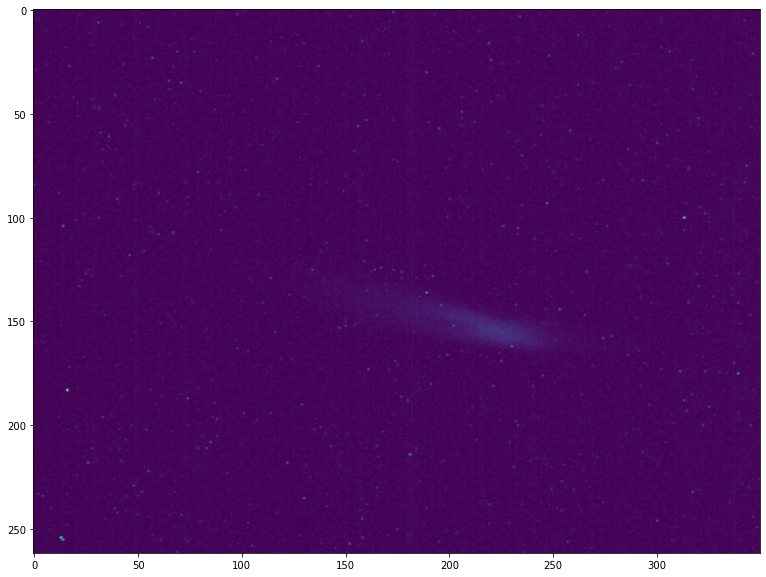

In [268]:
plt.figure(figsize=(15,10))
plt.imshow(otr_im)

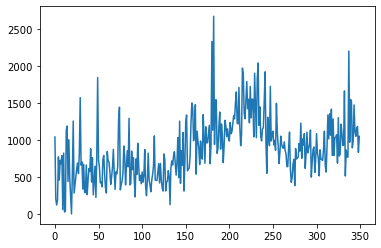

In [269]:
plt.plot(im.x_projection(otr_im))

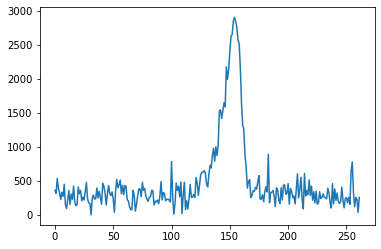

In [270]:
plt.plot(im.y_projection(otr_im))

In [271]:
# no clue what this does
#x_fit = im.gauss_fit(x_proj)
#y_fit = im.gauss_fit(y_proj)

In [280]:
def im_projection(image, axis=0, subtract_baseline=True):
    """Expects ndarray, return x (axis=0) or y (axis=1) projection"""
    proj = np.sum(image, axis)
    if subtract_baseline:
        return proj - min(proj)
    return proj

def gaussian_linear_background(x, amp, mu, sigma, slope, offset):
    return amp*np.exp( -(x-mu)**2/2/sigma**2 ) + slope * x + offset 

def fit_gaussian_linear_background_v2(x, y, para0 = None):
    if para0 == None:
        offset0 =  np.mean(y[-5:]) #y.min()
        amp0 = y.max() - offset0
        mu0 = x[np.argwhere(y==y.max())][0].item() # get the first element if more than two 
        try:
            sigma0 = (x[np.argwhere(y>np.exp(-0.5*2**2)*amp0+offset0).max()] - x[np.argwhere(y>np.exp(-0.5*2**2)*amp0+offset0).min()] )/(2*2)
        except:
            sigma0 = 5
        slope0 = 0
        para0 = [amp0, mu0, sigma0, slope0, offset0]
        
    try:
        para, para_error = curve_fit(gaussian_linear_background, x, y, p0 = para0)
    except:
        print("Fitting failed.")
        para = para0 
        para_error = []
    
    para[2] = abs(para[2])  # Gaussian width is postivie definite
    # contraints on the output fit parameters
    if para[2] >= len(x):
        para[2] = len(x)
        
    if abs(para[1]) <= 0:
        para[1] = 0
        
    if abs(para[1]) >= len(x):
        para[1] = len(x)
    return para, np.sqrt(np.diag(para_error_x)) #STD

In [281]:
def image_analysis(image, bg_image=None):
    if bg_image is not None and image.shape==bg_image.shape:
        image = image - bg_image

    x_proj = im_projection(image, axis=0)
    y_proj = im_projection(image, axis=1)

    xx = np.arange(x_proj.shape[0])
    yy = np.arange(y_proj.shape[0])

    # Gaussian fit
    para_x, para_error_x = fit_gaussian_linear_background_v2(xx, x_proj, para0 = None)
    para_y, para_error_y = fit_gaussian_linear_background_v2(yy, y_proj, para0 = None)
    
    # TODO: Add optional plotting and save plots of fitting
    
    return para_x[2], para_error_x[2], para_y[2], para_error_y[2]

In [282]:
image_analysis(otr_im)

(29.364520210121075, 3.3942399178714044, 7.486456410192251, 3.3942399178714044)

In [275]:
x_proj = im_projection(otr_im, axis=0)
y_proj = im_projection(otr_im, axis=1)

xx = np.arange(x_proj.shape[0])
yy = np.arange(y_proj.shape[0])


# Gaussian fit
para_x, para_error_x = fit_gaussian_linear_background_v2(xx, x_proj, para0 = None)
para_y, para_error_y = fit_gaussian_linear_background_v2(yy, y_proj, para0 = None)

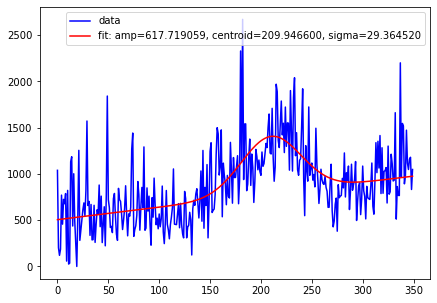

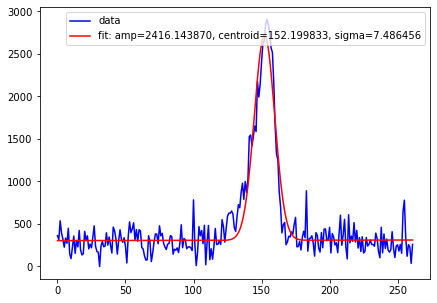

In [276]:
fig = plt.figure(figsize=(7 ,5))
plt.plot(xx, x_proj, 'b-', label='data')
plt.plot(xx, gaussian_linear_background(xx, *para_x), 'r-', label='fit: amp=%f, centroid=%f, sigma=%f' % tuple(para_x[:3]))
plt.legend()
plt.show()

fig = plt.figure(figsize=(7,5))
plt.plot(yy, y_proj, 'b-', label='data')
plt.plot(yy, gaussian_linear_background(yy, *para_y), 'r-', label='fit: amp=%f, centroid=%f, sigma=%f' % tuple(para_y[:3]))
plt.legend()
plt.show()

In [278]:
print(para_x)
print(para_error_x) # The estimated covariance of popt. The diagonals provide the variance of the parameter estimate. To compute one standard deviation errors on the parameters use perr = np.sqrt(np.diag(pcov)).
print(np.sqrt(np.diag(para_error_x)))

[617.71905949 209.94660047  29.36452021   1.34510299 505.70311527]
[[ 3.18045817e+03  5.82503725e+00  5.99041567e+01 -1.47600281e+00
  -1.46169664e+02]
 [ 5.82503725e+00  9.11584123e+00 -5.53529275e-01 -1.28741831e-01
   1.87920103e+01]
 [ 5.99041567e+01 -5.53529275e-01  1.15208646e+01  1.40258856e-01
   1.38973067e+01]
 [-1.47600281e+00 -1.28741831e-01  1.40258856e-01  3.26205323e-02
  -4.76142277e+00]
 [-1.46169664e+02  1.87920103e+01  1.38973067e+01 -4.76142277e+00
   1.20637058e+03]]
[56.39555094  3.01924514  3.39423992  0.18061155 34.73284579]


# ==================================

In [2]:
im1 = "../../../image_processing/emittance_scans_mat_files/Emittance-scan-OTRS_IN20_571-2021-06-08-201153.mat"

In [137]:
imat1 = scipy.io.loadmat(im1)
imat1['data'][0].dtype.names

('status',
 'type',
 'name',
 'quadName',
 'quadVal',
 'use',
 'ts',
 'beam',
 'beamStd',
 'beamList',
 'chargeList',
 'charge',
 'chargeStd',
 'rMatrix',
 'twiss0',
 'energy',
 'twiss',
 'twissstd',
 'orbit',
 'orbitstd',
 'twissPV')

70


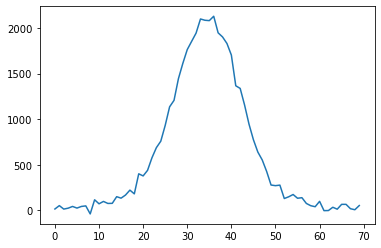

In [138]:
plt.plot(imat1['data'][0]['beam'][0][0,0]["profx"][1])
print((len(imat1['data'][0]['beam'][0][0,0]["profx"][1])))

36


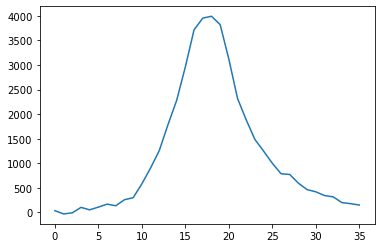

In [224]:
plt.plot(imat1['data'][0]['beam'][0][0,0]["profy"][1])
print((len(imat1['data'][0]['beam'][0][0,0]["profy"][1])))

# ==================================